In [117]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
from pycaret.classification import *

In [118]:
diabetes = pd.read_csv(r"C:\Users\adamt\notebooks\ca4015\diabetes.csv")
columns = diabetes.columns
print(diabetes.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [119]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

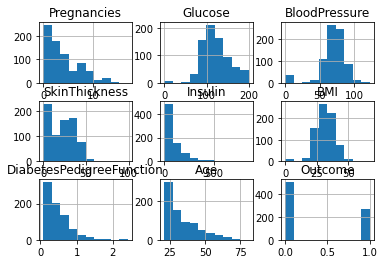

In [120]:
diabetes.hist()

In [121]:
x = diabetes.drop("Outcome", axis=1)
y = diabetes.Outcome

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [122]:
clf = RandomForestClassifier(n_estimators=200, max_depth=2, random_state=42, max_leaf_nodes=5)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7272727272727273
[[93  7]
 [35 19]]
              precision    recall  f1-score   support

           0       0.73      0.93      0.82       100
           1       0.73      0.35      0.48        54

    accuracy                           0.73       154
   macro avg       0.73      0.64      0.65       154
weighted avg       0.73      0.73      0.70       154



In [123]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, random_state=42, max_leaf_nodes=4), n_estimators=200, algorithm="SAMME.R", learning_rate=1)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7662337662337663
[[82 18]
 [18 36]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       100
           1       0.67      0.67      0.67        54

    accuracy                           0.77       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154



In [124]:
print(clf.feature_names_in_)
for name, score in zip(columns, clf.feature_importances_):
    print(name, score)

['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age']
Pregnancies 0.05869154707376609
Glucose 0.3838734444679899
BloodPressure 0.024804537726245763
SkinThickness 0.031051142452318718
Insulin 0.06878071999614312
BMI 0.19737105696084123
DiabetesPedigreeFunction 0.05531931851019693
Age 0.1801082328124983


In [125]:
scores = cross_val_score(clf, x, y, cv=5)
print(scores)

[0.74025974 0.74675325 0.74675325 0.75816993 0.75816993]


In [126]:
scores = cross_val_score(ada_clf, x, y, cv=5)
print(scores)

[0.70779221 0.68181818 0.72077922 0.79738562 0.69934641]


In [129]:
diabetes.shape
exp_name = setup(diabetes, target="Outcome", fold_shuffle=True)

,Description,Value
0,session_id,3640
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(768, 9)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'